In [1]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

# Inspect directory
os.listdir(path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


['seg_train', 'seg_pred', 'seg_test']

In [2]:
train_dir = os.path.join(path, "seg_train", "seg_train")
test_dir = os.path.join(path, "seg_test", "seg_test")

print("Train Classes:", os.listdir(train_dir))

Train Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [3]:
from collections import Counter

class_counts = {}

for cls in os.listdir(train_dir):
    class_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print(class_counts)

{'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 383ms/step - accuracy: 0.4197 - loss: 5.0023 - val_accuracy: 0.2603 - val_loss: 5.4780
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 267ms/step - accuracy: 0.5129 - loss: 1.2997 - val_accuracy: 0.6476 - val_loss: 0.9217
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.5934 - loss: 1.0980 - val_accuracy: 0.4979 - val_loss: 1.3431
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 272ms/step - accuracy: 0.6018 - loss: 1.0672 - val_accuracy: 0.6576 - val_loss: 0.9303
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 267ms/step - accuracy: 0.6345 - loss: 0.9638 - val_accuracy: 0.7250 - val_loss: 0.7656
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.6462 - loss: 0.9470 - val_accuracy: 0.6455 - val_loss: 1.0567
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 271ms/step - accuracy: 0.6694 - loss: 0.9098 - val_accuracy: 0.5360 - val_loss: 1.3091
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.6998 - loss: 

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

IMG_SIZE = 150

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipython-input-1347292401.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 135s 339ms/step - accuracy: 0.6971 - loss: 0.8220 - val_accuracy: 0.8752 - val_loss: 0.3510
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.8487 - loss: 0.4362 - val_accuracy: 0.8762 - val_loss: 0.3295
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.8529 - loss: 0.3969 - val_accuracy: 0.8834 - val_loss: 0.3184
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 264ms/step - accuracy: 0.8568 - loss: 0.3778 - val_accuracy: 0.8887 - val_loss: 0.3250
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 270ms/step - accuracy: 0.8725 - loss: 0.3558 - val_accuracy: 0.8762 - val_loss: 0.3244


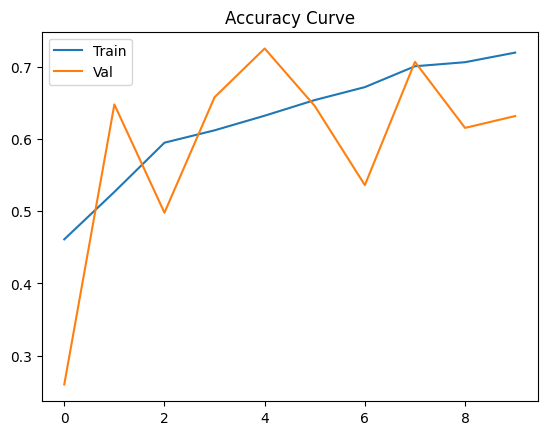

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train','Val'])
plt.title("Accuracy Curve")
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.7415 - loss: 1.0073
Test Accuracy: 0.7149999737739563
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       437
           1       0.93      0.92      0.93       474
           2       0.86      0.32      0.47       553
           3       0.58      0.65      0.61       525
           4       0.59      0.78      0.67       510
           5       0.75      0.86      0.80       501

    accuracy                           0.71      3000
   macro avg       0.74      0.73      0.71      3000
weighted avg       0.74      0.71      0.70      3000



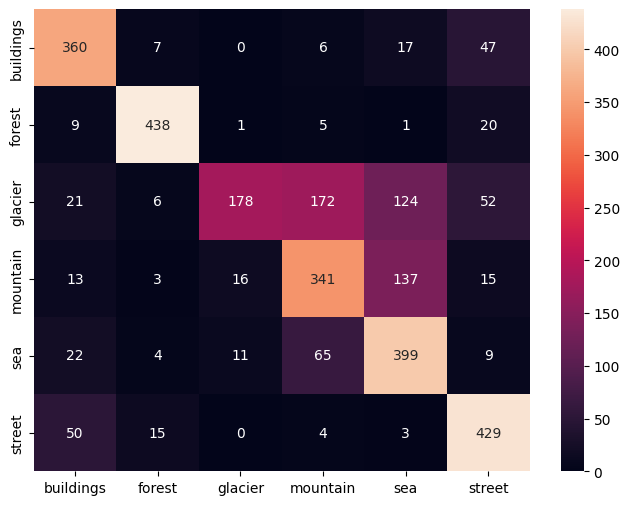

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.show()

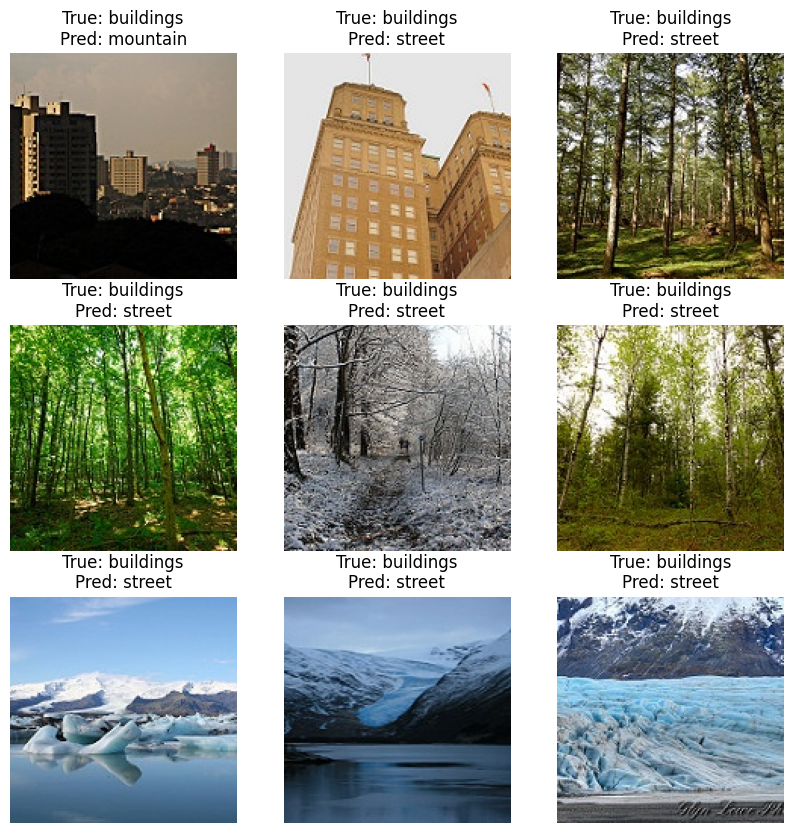

In [11]:
import matplotlib.pyplot as plt

misclassified = np.where(y_pred != y_true)[0]

plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified[:9]):
    img, label = test_generator[idx]
    plt.subplot(3,3,i+1)
    plt.imshow(img[0])
    plt.title(f"True: {list(test_generator.class_indices.keys())[y_true[idx]]}\nPred: {list(test_generator.class_indices.keys())[y_pred[idx]]}")
    plt.axis('off')
plt.show()

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/tmp/ipython-input-1391139004.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 114s 300ms/step - accuracy: 0.7202 - loss: 0.7904 - val_accuracy: 0.8720 - val_loss: 0.3538
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 92s 262ms/step - accuracy: 0.8368 - loss: 0.4439 - val_accuracy: 0.8738 - val_loss: 0.3381
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.8508 - loss: 0.4028 - val_accuracy: 0.8805 - val_loss: 0.3175
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - accuracy: 0.8665 - loss: 0.3763 - val_accuracy: 0.8894 - val_loss: 0.3120
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - accuracy: 0.8695 - loss: 0.3614 - val_accuracy: 0.8841 - val_loss: 0.3081


In [13]:
model2.save("scene_classifier.h5")

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7415 - loss: 1.0073
Test Accuracy: 0.7149999737739563


In [15]:
test_loss, test_acc = model2.evaluate(test_generator)
print("Test Accuracy:", test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.9031 - loss: 0.2455
Test Accuracy: 0.8926666378974915


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       437
           1       0.93      0.92      0.93       474
           2       0.86      0.32      0.47       553
           3       0.58      0.65      0.61       525
           4       0.59      0.78      0.67       510
           5       0.75      0.86      0.80       501

    accuracy                           0.71      3000
   macro avg       0.74      0.73      0.71      3000
weighted avg       0.74      0.71      0.70      3000



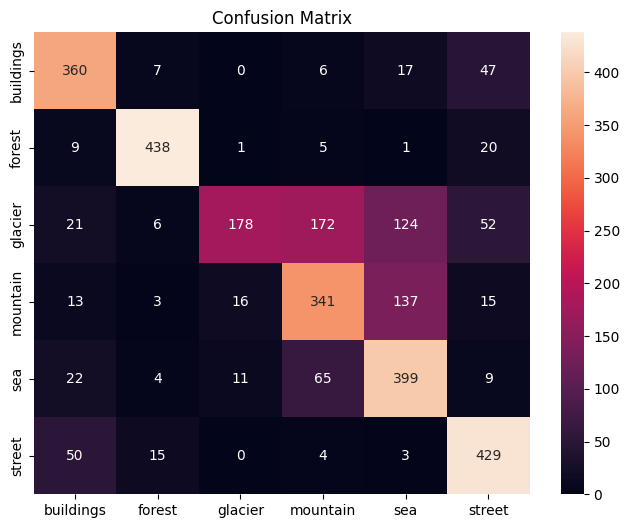

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


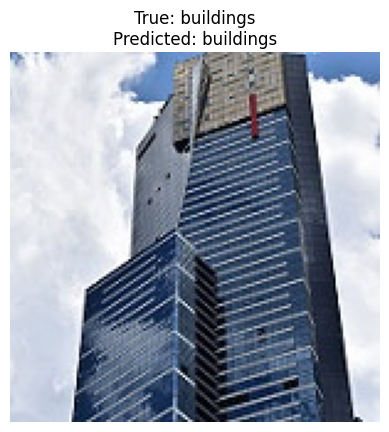

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
images, labels = next(test_generator)

# Predict
pred = model.predict(images)
pred_class = np.argmax(pred[0])
true_class = np.argmax(labels[0])

class_names = list(test_generator.class_indices.keys())

plt.imshow(images[0])
plt.title(f"True: {class_names[true_class]}\nPredicted: {class_names[pred_class]}")
plt.axis('off')
plt.show()

In [18]:
from google.colab import files
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
    img = cv2.imread(fn)
    img = cv2.resize(img, (150,150))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    class_names = list(test_generator.class_indices.keys())
    print("Predicted Class:", class_names[predicted_class])

Saving 24118.jpg to 24118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Predicted Class: street
